In [1]:
import numpy as np
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
from ukf  import *
from utils import *
from torch.utils.data import DataLoader
import pandas as pd

In [2]:
overall_path = 'C:/Users/user/project/generate_ev_data/data/overall_pd.csv'
trip_path = 'C:/Users/user/project/generate_ev_data/data/trip_pd.csv'
v_nums = [i for i in range(100)]
routes = [0]

ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
print(len(ev_dataset))

23595


In [3]:
model = ANN(activation='relu', layers=[3, 4, 8, 16, 8, 4, 1])

optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001)
loss = torch.nn.functional.l1_loss

In [4]:
if os.path.isfile('initial_model.pt'):
    print('Initial model exists')
    
else:
    v_nums = [i for i in range(100)]
    routes = [0]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=256, shuffle=True)
    epochs = 40

    loss_history = [[], []]

    start_time = time.time()
    for _ in range(epochs):
        model.train()
        train_loss = 0
        for inp, tar in train_loader:
            optimizer.zero_grad()
            output = model(inp)
            l = loss(output, tar)
            l.backward()
            optimizer.step()
            train_loss += l.item()
        train_loss /= len(train_loader)

        loss_history[0].append(_)
        loss_history[1].append(train_loss)

        if (_ % 5 == 0) or (_+1 == epochs):
            print(f'epoch num {_} loss : {train_loss}')

    print(f'time : {time.time() - start_time : .2f}')

    plt.plot(loss_history[0], loss_history[1], label='train_loss')
    plt.legend()
    plt.xlabel('Epoch number')
    plt.ylabel('MAE loss')
    plt.show()

    torch.save({
        'epoch' : epochs,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict' : optimizer.state_dict(),
        'loss' : loss
    }, 'initial_model.pt')

Initial model exists


In [5]:
checkpoint = torch.load('initial_model.pt')
print(checkpoint.keys())

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])


In [6]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss = checkpoint['loss']
epoch = checkpoint['epoch']

In [8]:
v0_model = deepcopy(model)
v0_optimizer = torch.optim.Adam(params=v0_model.parameters(), lr = 0.001)
epochs = 40
v_nums = [0]


dict_keys = ['route_num', 'initial_model_loss', 'update_model_loss', 'update_trigger']
dict_values = [[], [], [], []]
loss_hist = dict(zip(dict_keys, dict_values))
log_dir = 'runs/backprop/' + time.strftime("%m%d%H%M", time.gmtime()) + '/'
model_parameters = []
model_parameters.append(model_parameter_list(v0_model))

model.eval()
for route_num in range(1, 100):
    routes = [route_num]
    ev_dataset = EV_dataset(overall_path, trip_path, v_nums, routes)
    train_loader = DataLoader(ev_dataset, batch_size=512, shuffle=True)

    v0_model.eval()

    l_0, l_1 = 0, 0
    for inp, tar in train_loader:
        output_ = model(inp)
        i_loss = loss(output_, tar)
        l_0 += i_loss.item()

        output_0 = v0_model(inp)
        v0_loss = loss(output_0, tar)
        l_1 += v0_loss.item()
    l_0 /= len(train_loader)
    l_1 /= len(train_loader)

    if l_1 > 0.05:
        print(f'Model updated at route number {route_num},', end=' ')
        loss_hist['update_trigger'].append(route_num)
        writer = SummaryWriter(log_dir + str(route_num))
        v0_model.train()
        for i in range(epochs):
            l_1 = 0
            for inp, tar in train_loader:
                v0_optimizer.zero_grad()
                output = v0_model(inp)
                v0_loss = loss(output, tar)
                v0_loss.backward()
                v0_optimizer.step()
                l_1 += v0_loss.item()
            l_1 /= len(train_loader)
            writer.add_scalar('train_loss', l_1, i)

        model_parameters.append(model_parameter_list(v0_model))
        print('Update complete')

    loss_hist['route_num'].append(route_num)
    loss_hist['initial_model_loss'].append(l_0)
    loss_hist['update_model_loss'].append(l_1)

print('model updated {} times after initial model'.format(len(loss_hist['update_trigger'])))
loss_hist['model_parameters'] = model_parameters
np.save('./result/backprop.npy', loss_hist)

Model updated at route number 14, Update complete
Model updated at route number 25, Update complete
Model updated at route number 38, Update complete
Model updated at route number 44, Update complete
Model updated at route number 54, Update complete
Model updated at route number 61, Update complete
Model updated at route number 68, Update complete
Model updated at route number 72, Update complete
Model updated at route number 76, Update complete
Model updated at route number 80, Update complete
Model updated at route number 85, Update complete
Model updated at route number 90, Update complete
Model updated at route number 94, Update complete
Model updated at route number 97, Update complete
model updated 14 times after initial model


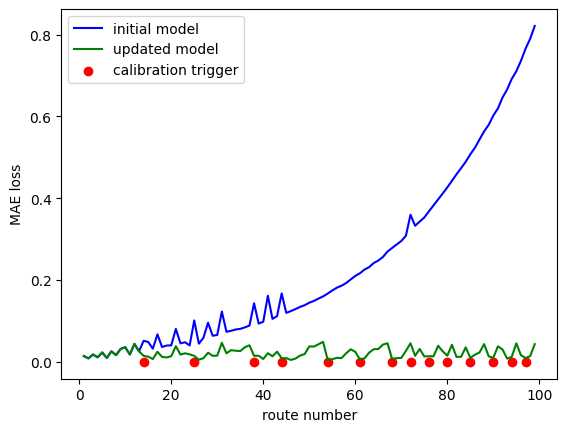

In [9]:
plt.plot(loss_hist['route_num'], loss_hist['initial_model_loss'], label = 'initial model', c='b')
plt.plot(loss_hist['route_num'], loss_hist['update_model_loss'], label = 'updated model', c='g')
plt.scatter(loss_hist['update_trigger'], [0 for _ in loss_hist['update_trigger']], label = 'calibration trigger', c='r')
plt.legend()
plt.xlabel('route number')
plt.ylabel('MAE loss')
plt.savefig('retrain_loss_backprop.png')
plt.show()